<h1>SCA using neural networks</h1>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, InputLayer, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


<h3>Load the data</h3>

In [93]:
filename = './extradatasets/ASCAD_desync50.h5'

In [94]:
def load_ascad(file_path):
    with h5py.File(file_path, 'r') as f:
        X_profiling = np.array(f['Profiling_traces/traces'])
        Y_profiling = np.array(f['Profiling_traces/labels'])
        X_attack = np.array(f['Attack_traces/traces'])
        Y_attack = np.array(f['Attack_traces/labels'])
        
        metadata_attack = f['Attack_traces/metadata']
        plaintexts_attack = np.array(metadata_attack['plaintext'])
        key = np.array(metadata_attack['key'])
    
    return (X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key

<h3>Visualize the data</h3>

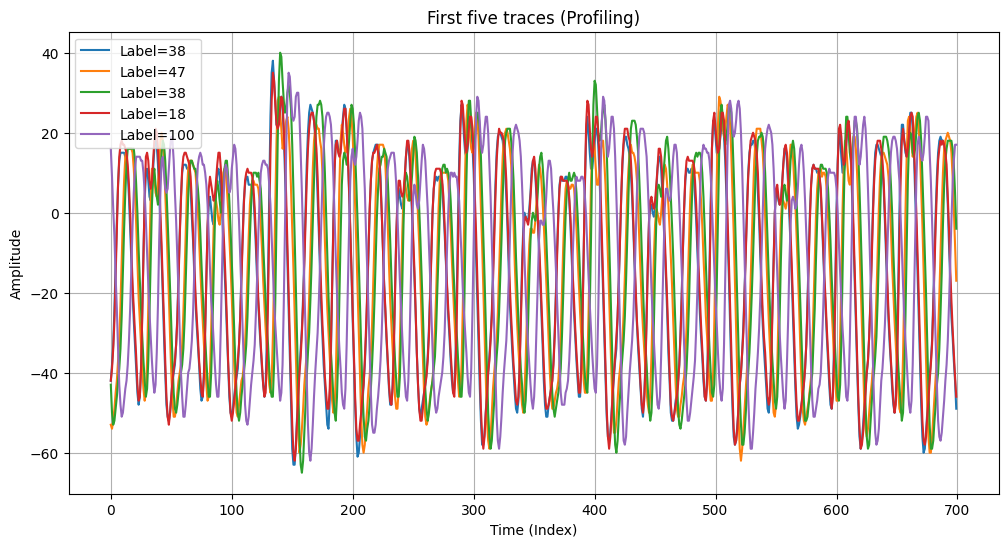

In [95]:
(X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key = load_ascad(filename)
X_train, X_val, Y_train, Y_val = train_test_split(X_profiling, Y_profiling, test_size=0.1, random_state=42)

num_traces_to_plot = 5

plt.figure(figsize=(12, 6))
for i in range(num_traces_to_plot):
    plt.plot(X_profiling[i], label=f"Label={Y_profiling[i]}")

plt.title("First five traces (Profiling)")
plt.xlabel("Time (Index)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

<h3>Split data into trainig, validation and test</h3>

In [96]:
print("Trazas de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", Y_train.shape)
print("Trazas de validación:", X_val.shape)
print("Etiquetas de validación:", Y_val.shape)
print("Trazas de ataque:", X_attack.shape)
print("Etiquetas de ataque:", Y_attack.shape)   

Trazas de entrenamiento: (45000, 700)
Etiquetas de entrenamiento: (45000,)
Trazas de validación: (5000, 700)
Etiquetas de validación: (5000,)
Trazas de ataque: (10000, 700)
Etiquetas de ataque: (10000,)


<h3>Preprocessing data</h3>

In [97]:
Y_profiling = to_categorical(Y_profiling, num_classes=256)
Y_train = to_categorical(Y_train, num_classes=256)
Y_val = to_categorical(Y_val, num_classes=256)
Y_attack = to_categorical(Y_attack, num_classes=256)

X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))

<h3>Build VGG16 based model</h3>

In [ ]:
model = Sequential([
    InputLayer(shape=(X_profiling.shape[1], 1)),

    Conv1D(filters=64, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=128, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=256, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=512, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=512, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),

    # output layer
    Dense(256, activation='softmax'),
])

optimizer = RMSprop(learning_rate=0.00001)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='models/best_model1.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)              │ (None, 700, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_25            │ (None, 350, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 350, 128)       │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_26            │ (None, 175, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 175, 256)       │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_27            │ (None, 87, 256)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 87, 512)        │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_28            │ (None, 43, 512)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 43, 512)        │     2,884,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_29            │ (None, 21, 512)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    44,044,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,652,544 (254.26 MB)

 Trainable params: 66,652,544 (254.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, Y_train, epochs=75 , batch_size=200, validation_data=(X_val, Y_val), verbose=1, callbacks=[checkpoint])
model.save('models/ascad_model12.h5')

<h3>Evaluate model performance</h3>

In [ ]:
history = model.history.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
AES_SBOX = np.array([
		0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
		0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
		0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
		0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
		0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
		0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
		0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
		0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
		0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
		0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
		0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
		0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
		0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
		0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
		0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
		0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
		])

def perform_SCA_Atack(model, X_attack, plaintexts, real_key_byte, byte_index=0, num_attacks=10, num_traces_per_attack=1000):
    all_ge_results = []
    all_sr_results = []

    for _ in range(num_attacks):
        indices = np.random.permutation(len(X_attack))[:num_traces_per_attack]
        X_subset = X_attack[indices]
        pt_subset = plaintexts[indices]

        predictions = model.predict(X_subset)
        key_guesses = np.zeros(256, dtype=np.float64)
        GE = []
        SR = []

        for trace_idx in range(num_traces_per_attack):
            pt_byte = pt_subset[trace_idx][byte_index]
            for kguess in range(256):
                sbox_out = AES_SBOX[pt_byte ^ kguess]
                key_guesses[kguess] += np.log(predictions[trace_idx][sbox_out] + 1e-36)

            sorted_guesses = np.argsort(key_guesses)[::-1]
            rank = list(sorted_guesses).index(real_key_byte)
            GE.append(rank)
            SR.append(1 if rank == 0 else 0)

            if rank == 0 and (len(GE) == 1 or GE[-2] != 0):
                print(f"Correct key first ranked at trace {trace_idx+1}")

        all_ge_results.append(GE)
        all_sr_results.append(SR)

    max_len = max(len(sr) for sr in all_sr_results)
    all_sr_padded = [sr + [sr[-1]] * (max_len - len(sr)) for sr in all_sr_results]

    ge_mean = np.mean(all_ge_results, axis=0)
    ge_std = np.std(all_ge_results, axis=0)
    sr_mean = np.mean(all_sr_padded, axis=0)

    plot_guessing_entropy(ge_mean, ge_std)
    plot_sr(sr_mean)

    return ge_mean, ge_std, sr_mean

def plot_guessing_entropy(ge_mean, ge_std=None, title="Guessing Entropy"):
    plt.figure(figsize=(10, 6))
    plt.plot(ge_mean, label='Mean rank')
    
    if ge_std is not None:
        plt.fill_between(range(len(ge_mean)), 
                        ge_mean - ge_std,
                        ge_mean + ge_std,
                        alpha=0.3)
    
    plt.grid(True)
    plt.xlabel('Number of traces')
    plt.ylabel('Rank of correct key')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

def plot_sr(sr_mean, title="Success Rate"):
    plt.figure(figsize=(10, 6))
    plt.plot(sr_mean, label='Mean Success Rate')
    plt.grid(True)
    plt.xlabel('Number of traces')
    plt.ylabel('Success Rate')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Correct key first ranked at trace 193
Correct key first ranked at trace 203
Correct key first ranked at trace 216
Correct key first ranked at trace 264
Correct key first ranked at trace 267
Correct key first ranked at trace 279
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


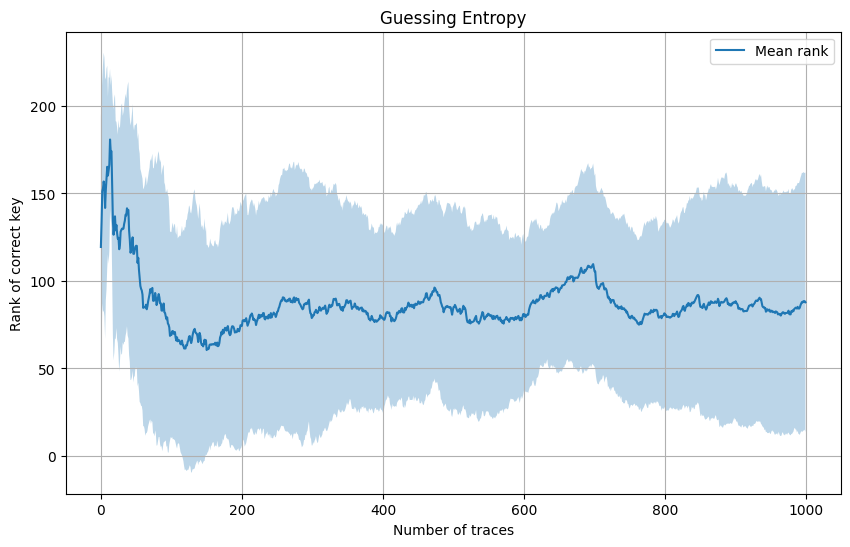

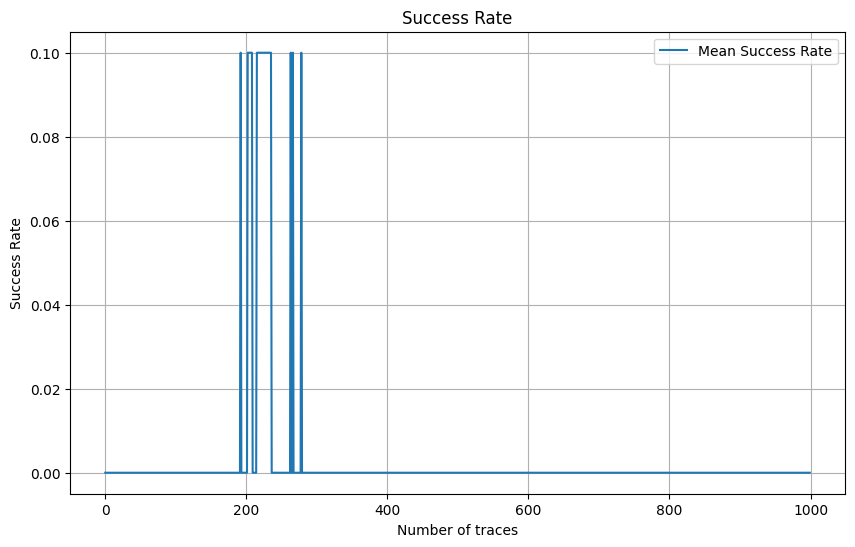

In [151]:
model = load_model('models/ascad_model1.h5')

ge_mean, ge_std, sr_mean = perform_SCA_Atack(
    model, X_attack, plaintexts_attack, real_key_byte=key[0][0], byte_index=0, num_attacks=10, num_traces_per_attack=1000
)